# Crews MPN RNASeq Analysis

### Aged Bone Marrow (normal control) vs. Myeloproliferative Neoplasms (MPN) 
### Genes/Isoforms
* ADAR1


In [1]:
library(IRdisplay)
library('limma')
library('edgeR')
library('ggplot2')
library('ggpubr')
library('org.Hs.eg.db')
library('genefilter')
library('Homo.sapiens')
library('splitstackshape')
library('statmod')
library('plyr')
library('dplyr')
library('gdata')
library('reshape2')


EG2SYM <- toTable(org.Hs.egSYMBOL)
ENS2EG <- toTable(org.Hs.egENSEMBL2EG)
ENS2EG2SYM <- data.frame(gene_id=ENS2EG$gene_id, ens_id=ENS2EG,                 
                         SYM=EG2SYM[match(ENS2EG$gene_id,EG2SYM$gene_id),"symbol"])

Warning message:
“package ‘IRdisplay’ was built under R version 4.1.0”
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, r

### Preprocess RNASeq Gene Count Data and metadata

In [2]:
meta2 <- read.csv("../data/combined_meta2.csv", stringsAsFactors=FALSE)
types <- unlist(lapply(meta2$ID, function(x) strsplit(x, split="\\.")[[1]][2]))  
meta2$CellType <- rep("BM", nrow(meta2))
meta2$CellType[which(!meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))] <- types[which(!meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))]
meta2$Sample.type2 <- recode(meta2$Sample.type, `Aged normal bone marrow`="NBM", `Young normal bone marrow`="NBM")
meta2$Sample.type3 <- meta2$Phenotype <- recode(meta2$Sample.type, `Aged normal bone marrow`="ABM", 
                                                `Young normal bone marrow`="YBM")

meta2$Sample.type4 <- recode(meta2$Sample.type3, sAML="sAML_UnTx", `de novo AML`="sAML_UnTx", AML="sAML_Tx")                       
meta2$Sample.type2 <- gsub("^AML$", "sAML", meta2$Sample.type2)
meta2$Sample.type3 <- gsub("^AML$", "sAML", meta2$Sample.type3)
meta2$Sample.type2[which(meta2$Condition == "de novo AML")] <- "dnAML"
meta2$Sample.type3[which(meta2$Condition == "de novo AML")] <- "dnAML"

meta2$Phenotype <- recode(meta2$Sample.type, `Aged normal bone marrow`="ABM", `Young normal bone marrow`="YBM")
meta2$Phenotype[which(meta2$Sample.type %in% c("Young normal bone marrow"))] <- "YBM"

meta2.Prog.filt <- meta2[meta2$Sample.type3 %in% c("ABM", "YBM", "CML", "sAML", "ET", "PV", "MF", "dnAML") & 
                         meta2$Cell.type %in% c("Progenitor", "Sorted progenitors"),]
meta2.Prog.filt$Phenotype <- factor(as.character(meta2.Prog.filt$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
                         
meta2.Prog.all.filt <- meta2[meta2$Cell.type %in% c("Sorted progenitors", "Progenitor"),]

meta2.Stem.filt <- meta2[meta2$Phenotype %in% c("ABM", "YBM", "CML", "AML", "ET", "PV", "MF") & 
                         meta2$Cell.type %in% c("Stem", "Sorted stem"),] 
meta2.Stem.filt$Phenotype <- factor(as.character(meta2.Stem.filt$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
meta2.Stem.all.filt <- meta2[meta2$Cell.type %in% c("Sorted stem", "Stem"),]


In [3]:
meta <- read.csv("../data/fheditsHolm_Jamieson_RNAseq_with_controls_meta_20200303.csv", header=TRUE, stringsAsFactors = FALSE)
meta$Phenotype <- meta$Condition_code2
meta$Phenotype[which(meta$Condition_code2 %in% c("Aged_Normal","Young_Normal"))] <- "Normal"
meta$Phenotype2 <- meta$Condition_code2 
meta$Phenotype2[which(meta$Condition_code2 %in% c("Aged_Normal"))] <- "ABM"
meta$Phenotype2[which(meta$Condition_code2 %in% c("Young_Normal"))] <- "YBM"
meta$Phenotype3 <- recode(meta$Phenotype2, sAML="sAML_UnTx", AML="sAML_Tx")

meta_filt <- subset(meta, Phenotype %in% c("Normal", "MF", "PV", "ET", "CML", "AML", "denovoAML", "sAML") & 
                       Cell.type %in% c("Stem", "Progenitor"))
meta_filt$JAK2 <- meta_filt$Mutation
meta_filt$JAK2[meta_filt$JAK2 %in% c("JAK2V617F+","JAK2 V617F+")] <- "V617F+"
meta_filt$JAK2[meta_filt$JAK2 %in% c("JAK2 V617F-")] <- "V617F-"
meta_filt$JAK2[!meta_filt$JAK2 %in% c("V617F-", "V617F+")] <- NA
meta_filt$Tissue <- meta_filt$Tissue.Type
meta_filt$Cells <- meta_filt$Cell.type


meta2.Prog.filt$Treatment_code2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Treatment_code2"]))
meta2.Stem.filt$Treatment_code2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Treatment_code2"]))
meta2.Prog.filt$Phenotype2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype2"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML", "sAML", "denovoAML"))
meta2.Prog.filt$Phenotype3 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype3"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "sAML_UnTx", "AML_Tx"))
meta2.Prog.filt$Phenotype4 <- factor(as.character(meta2.Prog.filt$Sample.type3),
                                     levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "sAML", "dnAML"))
meta2.Stem.filt$Phenotype2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype2"]),  
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML", "sAML", "denovoAML"))

In [4]:
meta2.Prog <- meta2[meta2$Cell.type %in% c("Progenitor", "Sorted progenitors"),]
meta2.Prog$Phenotype <- factor(as.character(meta2.Prog$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "AML"))
    
meta_filt2 <- subset(meta, Cell.type %in% c("Stem", "Progenitor"))
meta_filt2$JAK2 <- meta_filt2$Mutation
meta_filt2$JAK2[meta_filt2$JAK2 %in% c("JAK2V617F+","JAK2 V617F+")] <- "V617F+"
meta_filt2$JAK2[meta_filt2$JAK2 %in% c("JAK2 V617F-")] <- "V617F-"
meta_filt2$JAK2[!meta_filt2$JAK2 %in% c("V617F-", "V617F+")] <- NA
meta_filt2$Tissue <- meta_filt2$Tissue.Type
meta_filt2$Cells <- meta_filt2$Cell.type

meta2.Prog$Treatment_code2 <- factor(as.character(meta_filt2[match(gsub("_S[0-9]+$","",meta2.Prog$Sample), 
                              gsub("_S[0-9]+$","",meta_filt2$Sample)),"Treatment_code2"]))
meta2.Prog$Phenotype2 <- factor(as.character(meta_filt2[match(gsub("_S[0-9]+$","",meta2.Prog$Sample), 
                              gsub("_S[0-9]+$","",meta_filt2$Sample)),"Phenotype2"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "AML", "sAML", "denovoAML"))
meta2.Prog$Phenotype3 <- factor(as.character(meta_filt2[match(gsub("_S[0-9]+$","",meta2.Prog$Sample), 
                              gsub("_S[0-9]+$","",meta_filt2$Sample)),"Phenotype3"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "sAML_UnTx", "AML_Tx"))
meta2.Prog$Phenotype4 <- factor(as.character(meta2.Prog$Sample.type3),
                                     levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "sAML", "dnAML"))

### Load RNASeq Isoform Count Data and metadata

In [5]:
# Available on request due to size limits
load("../data/crews_MPN_rnaseq_20220521_data.RData")

In [6]:
meta2.Prog.filt2 <- meta2.Prog.filt[-grep("X672A.PB.Prog_S3", meta2.Prog.filt$Sample),]
meta2.Prog.all.filt2 <- meta2.Prog.all.filt[-grep("X672A.PB.Prog_S3", meta2.Prog.all.filt$Sample),]


In [10]:
NBM.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type2 %in% c("NBM")),]
ABM.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Phenotype %in% c("ABM")),]
YBM.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Phenotype %in% c("YBM")),]
PV.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type %in% c("PV")),]
ET.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type %in% c("ET")),]
MF.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type %in% c("MF")),]
CML.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type %in% c("CML")),]
sAML.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type %in% c("sAML")),]
AML.Prog.meta.filt <- meta2.Prog.filt2[which(meta2.Prog.filt2$Sample.type %in% c("AML")),]

NBM.Prog.samps.f <- match(NBM.Prog.meta.filt$Sample, colnames(iso_counts_control_pc))
ABM.Prog.samps.f <- match(ABM.Prog.meta.filt$Sample, colnames(iso_counts_control_pc))
YBM.Prog.samps.f <- match(YBM.Prog.meta.filt$Sample, colnames(iso_counts_control_pc))

PV.Prog.samps.f <- match(gsub("_S[0-9]+$", "", PV.Prog.meta.filt$Sample), 
                       gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
ET.Prog.samps.f <- match(gsub("_S[0-9]+$", "", ET.Prog.meta.filt$Sample),
                       gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
MF.Prog.samps.f <- match(gsub("_S[0-9]+$", "", MF.Prog.meta.filt$Sample), 
                       gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
CML.Prog.samps.f <- match(gsub("_S[0-9]+$", "", CML.Prog.meta.filt$Sample), 
                        gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
sAML.Prog.samps.f <- match(gsub("_S[0-9]+$", "", sAML.Prog.meta.filt$Sample),
                        gsub("_S[0-9]+$", "", colnames(iso_counts_control_pc)))
AML.Prog.samps.f <- match(gsub("_S[0-9]+$", "", AML.Prog.meta.filt$Sample),
                        gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))

In [11]:
NBM.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Sample.type2 %in% c("NBM")),]
ABM.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Phenotype %in% c("ABM")),]
YBM.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Phenotype %in% c("YBM")),]
PV.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Sample.type %in% c("PV")),]
ET.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Sample.type %in% c("ET")),]
MF.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Sample.type %in% c("MF")),]
CML.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Sample.type %in% c("CML")),]
AML.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$Sample.type %in% c("AML")),]

NBM.Stem.samps.f <- match(NBM.Stem.meta.filt$Sample, colnames(iso_counts_control_pc))
ABM.Stem.samps.f <- match(ABM.Stem.meta.filt$Sample, colnames(iso_counts_control_pc))
YBM.Stem.samps.f <- match(YBM.Stem.meta.filt$Sample, colnames(iso_counts_control_pc))

PV.Stem.samps.f <- match(gsub("_S[0-9]+$", "", PV.Stem.meta.filt$Sample), 
                       gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
ET.Stem.samps.f <- match(gsub("_S[0-9]+$", "", ET.Stem.meta.filt$Sample),
                       gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
MF.Stem.samps.f <- match(gsub("_S[0-9]+$", "", MF.Stem.meta.filt$Sample), 
                       gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
CML.Stem.samps.f <- match(gsub("_S[0-9]+$", "", CML.Stem.meta.filt$Sample), 
                        gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))
AML.Stem.samps.f <- match(gsub("_S[0-9]+$", "", AML.Stem.meta.filt$Sample),
                        gsub("_S[0-9]+$", "", colnames(iso_counts_new_pc)))

### Prepare DGELists

In [12]:
iso_counts_filt.Prog.filt <- cbind(iso_counts_control_pc[,c(ABM.Prog.samps.f, YBM.Prog.samps.f)], 
                                   iso_counts_new_pc[,c(PV.Prog.samps.f, ET.Prog.samps.f, MF.Prog.samps.f,
                                                 CML.Prog.samps.f)], 
                                   iso_counts_control_pc[,sAML.Prog.samps.f], 
                                   iso_counts_new_pc[,AML.Prog.samps.f])
iso_counts_filt.Stem.filt <- cbind(iso_counts_control_pc[,c(ABM.Stem.samps.f, YBM.Stem.samps.f)], 
                             iso_counts_new_pc[,c(PV.Stem.samps.f, ET.Stem.samps.f, MF.Stem.samps.f,
                                                 CML.Stem.samps.f, AML.Stem.samps.f)])
id_list.Prog.filt <- gsub("[.].*$","", rownames(iso_counts_filt.Prog.filt))
id_list.Stem.filt <- gsub("[.].*$","", rownames(iso_counts_filt.Stem.filt))


In [13]:

iso_counts_all <- cbind(iso_counts_control_pc, iso_counts_new_pc)
iso_counts_filt.Prog.all.filt <- iso_counts_all[,match(gsub("_S[0-9]+$", "", meta2.Prog.all.filt2$Sample), 
                       gsub("_S[0-9]+$", "", colnames(iso_counts_all)))]
iso_counts_filt.Stem.all.filt <- iso_counts_all[,match(gsub("_S[0-9]+$", "", meta2.Stem.all.filt$Sample), 
                       gsub("_S[0-9]+$", "", colnames(iso_counts_all)))]

DGE_all.Prog.all.filt <- DGEList(counts = iso_counts_filt.Prog.all.filt, lib.size = colSums(iso_counts_filt.Prog.all.filt),
                      norm.factors = rep(1,ncol(iso_counts_filt.Prog.all.filt)), samples = meta2.Prog.all.filt2,
                      group = meta2.Prog.all.filt2$Phenotype, genes = id_list.Prog.filt, remove.zeros = FALSE) 
DGE_all.Prog.all.filt$genes[,2:3] <- iso_gene_table_anno_pc[match(gsub("[.].*$","", iso_gene_table_anno_pc$transcript_id),
                                          id_list.Prog.filt),c("ENTREZID","SYMBOL")]

DGE_all.Stem.all.filt <- DGEList(counts = iso_counts_filt.Stem.all.filt, lib.size = colSums(iso_counts_filt.Stem.all.filt),
                      norm.factors = rep(1,ncol(iso_counts_filt.Stem.all.filt)), samples = meta2.Stem.all.filt,
                      group = meta2.Stem.all.filt$Phenotype, genes = id_list.Stem.filt, remove.zeros = FALSE) 
DGE_all.Stem.all.filt$genes[,2:3] <- iso_gene_table_anno_pc[match(gsub("[.].*$","", iso_gene_table_anno_pc$transcript_id),
                                          id_list.Stem.filt),c("ENTREZID","SYMBOL")]

cpm.Prog.all.filt <- cpm(DGE_all.Prog.all.filt)
lcpm.Prog.all.filt <- cpm(DGE_all.Prog.all.filt, log=TRUE)
keep.exprs.Prog.filt <- rowSums(cpm.Prog.all.filt>1)>=15

DGE_all.Prog.all.filt <- DGE_all.Prog.all.filt[keep.exprs.Prog.filt,, keep.lib.sizes=FALSE]
DGE_all.Prog.all.filt <- calcNormFactors(DGE_all.Prog.all.filt, method = "TMM")

lcpm2.Prog.all.filt <- cpm(DGE_all.Prog.all.filt, log=TRUE)

cpm.Stem.all.filt <- cpm(DGE_all.Stem.all.filt)
lcpm.Stem.all.filt <- cpm(DGE_all.Stem.all.filt, log=TRUE)
keep.exprs.Stem.filt <- rowSums(cpm.Stem.all.filt>1)>=20
DGE_all.Stem.all.filt <- DGE_all.Stem.all.filt[keep.exprs.Stem.filt,, keep.lib.sizes=FALSE]
DGE_all.Stem.all.filt <- calcNormFactors(DGE_all.Stem.all.filt, method = "TMM")

lcpm2.Stem.all.filt <- cpm(DGE_all.Stem.all.filt, log=TRUE)

In [14]:
ADAR.tx.exp <- c("ENST00000368471", "ENST00000368474", "ENST00000529168")
ADAR.tx.exp.prog.lcpm <- lcpm2.Prog.all.filt[rownames(lcpm2.Prog.all.filt) %in% ADAR.tx.exp,]
ADAR.tx.exp.prog.df <- cbind.data.frame(DGE_all.Prog.all.filt$samples, as.data.frame(t(ADAR.tx.exp.prog.lcpm)))
colnames(ADAR.tx.exp.prog.df)[19:21] <- c("ADAR_201", "ADAR_202", "ADAR_208")
ADAR.tx.exp.prog.df <- subset(ADAR.tx.exp.prog.df, group == "ABM" | group == "YBM" | group == "sAML")


In [15]:
ADAR.tx.exp.prog.df2 <- cbind.data.frame(DGE_all.Prog.all.filt$samples, as.data.frame(t(ADAR.tx.exp.prog.lcpm)))
colnames(ADAR.tx.exp.prog.df2)[19:21] <- c("ADAR_201", "ADAR_202", "ADAR_208")
ADAR.tx.exp.prog.df2 <- subset(ADAR.tx.exp.prog.df2, group != "MDS")
ADAR.tx.exp.prog.df2.m <-  melt(ADAR.tx.exp.prog.df2[,-c(1:16,18)])
ADAR.tx.exp.prog.df2.m$Sample.type3 <- ADAR.tx.exp.prog.df2.m$Sample.type3 <- factor(as.character(ADAR.tx.exp.prog.df2.m$Sample.type3), 
                                           levels=c("YBM", "ABM", "PV", "ET", "MF", "CML", "dnAML", "sAML"))
ADAR.tx.exp.prog.df2.m$value <- sapply(ADAR.tx.exp.prog.df2.m$value, function(x) ifelse(x > 0, x, 0))


Using Sample.type3 as id variables



## Figure 1A - HPC

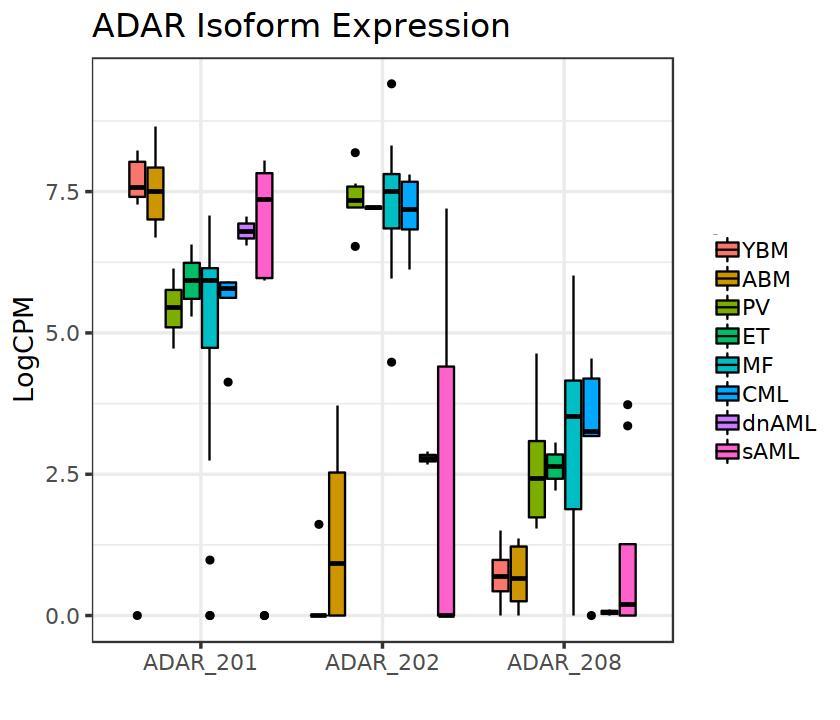

In [16]:
options(repr.plot.width=7, repr.plot.height=6)
plot_pal <- c('#F8766D', '#CD9600','#7CAE00','#00BE67','#00BFC4','#00A9FF','#C77CFF','#FF61CC')
ggboxplot(ADAR.tx.exp.prog.df2.m, x="variable", y="value", fill="Sample.type3", ylab="LogCPM", xlab="", 
          main="ADAR Isoform Expression", palette=plot_pal) +
                                      theme_bw(base_size=16) + theme(legend.title=element_text(size=0))
                                       

In [17]:
ADAR.tx.exp <- c("ENST00000368471", "ENST00000368474", "ENST00000529168")
ADAR.tx.exp.stem.lcpm <- lcpm2.Stem.all.filt[rownames(lcpm2.Stem.all.filt) %in% ADAR.tx.exp,]
ADAR.tx.exp.stem.df <- cbind.data.frame(DGE_all.Stem.all.filt$samples, as.data.frame(t(ADAR.tx.exp.stem.lcpm)))
colnames(ADAR.tx.exp.stem.df)[19:21] <- c("ADAR_201", "ADAR_202", "ADAR_208")


In [18]:
ADAR.tx.exp.Stem.df2 <- cbind.data.frame(DGE_all.Stem.all.filt$samples, as.data.frame(t(ADAR.tx.exp.stem.lcpm)))
colnames(ADAR.tx.exp.Stem.df2)[19:21] <- c("ADAR_201", "ADAR_202", "ADAR_208")
ADAR.tx.exp.Stem.df2 <- subset(ADAR.tx.exp.Stem.df2, group != "MDS")
ADAR.tx.exp.Stem.df2.m <-  melt(ADAR.tx.exp.Stem.df2[,-c(1:16,18)])
ADAR.tx.exp.Stem.df2.m$Sample.type3 <- ADAR.tx.exp.Stem.df2.m$Sample.type3 <- factor(as.character(ADAR.tx.exp.Stem.df2.m$Sample.type3), 
                                           levels=c("YBM", "ABM", "PV", "ET", "MF", "CML", "sAML"))
ADAR.tx.exp.Stem.df2.m$value <- sapply(ADAR.tx.exp.Stem.df2.m$value, function(x) ifelse(x > 0, x, 0))


Using Sample.type3 as id variables



## Figure 1A - HSC

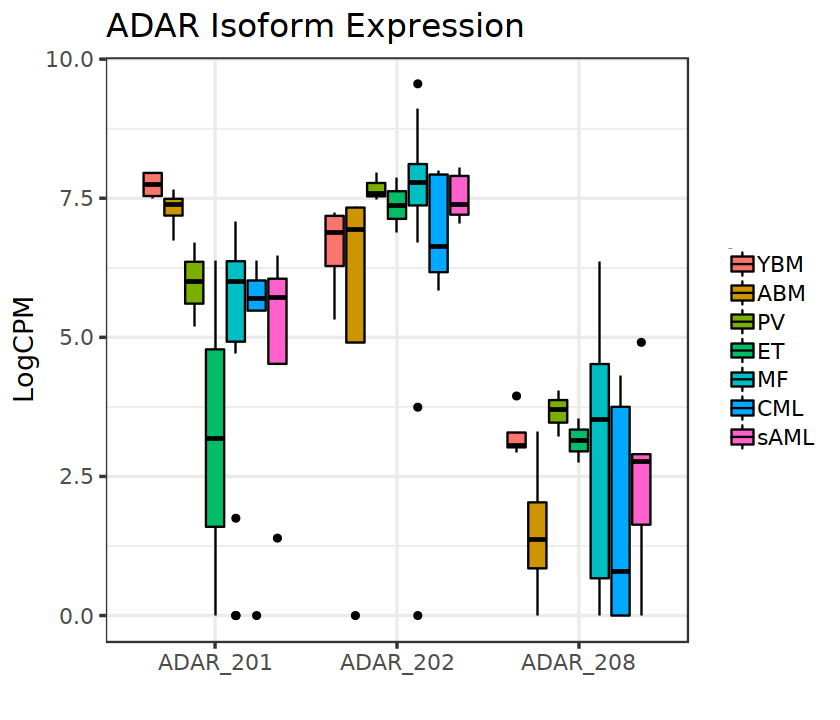

In [19]:
options(repr.plot.width=7, repr.plot.height=6)
plot_pal <- c('#F8766D', '#CD9600','#7CAE00','#00BE67','#00BFC4','#00A9FF','#C77CFF','#FF61CC')
ggboxplot(ADAR.tx.exp.Stem.df2.m, x="variable", y="value", fill="Sample.type3", ylab="LogCPM", xlab="", 
          main="ADAR Isoform Expression", palette=plot_pal[c(1:6,8)]) +
                                      theme_bw(base_size=16) + theme(legend.title=element_text(size=0))

In [1]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/ubuntu/anaconda3/lib/libmkl_rt.so.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_0.5.0     digest_0.6.29   utf8_1.2.2      crayon_1.4.2   
 [5] IRdisplay_1.0   repr_1.1.3      lifecycle_1.0.1 jsonlite_1.7.2 
 [9] evaluate_0.14   pillar_1.6.4    rlang_0.4.12    uuid_1.0-3     
[13] vctrs_0.3.8     ellipsis_0.3.2  IRkernel_1.3.1  tools_4.0.5    
[17] fastmap_1.1.0   compiler_4.0.5  base64enc_0.1-3 pbdZMQ_0.3-6   
[21] htmltools_0.5.2